In [1]:
import cobra
from cobra import Model, Reaction, Metabolite
from cobra.medium import minimal_medium
from train_functions import *
from feature_functions import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modify GEMs

In [ ]:
# st = cobra.io.read_sbml_model('../data/GEMs/iMP429.xml');
# ll = cobra.io.read_sbml_model('../data/GEMs/LL_MG1363.xml');

In [3]:
# ll.reactions.kaasIII.gene_reaction_rule = 'x_375'
    
# for met in st.metabolites:
#     temp_id = str(met.id)
#     met.id = temp_id.replace('LSQBKT','').replace('_RSQBKT','')

# for rxn in st.reactions.query('EX_'):
#     temp_id = str(rxn.id)
#     rxn.id = temp_id.replace('_LPAREN','').replace('_RPAREN_','')

# for rxn in ll.reactions.query('EX_'):
#     temp_id = str(rxn.id)
#     rxn.id = temp_id.replace('_LPAREN','').replace('_RPAREN_','')

In [4]:
# cobra.io.save_json_model( st , "../data/GEMs/ST_LMG18311.json")
# cobra.io.save_json_model( ll , "../data/GEMs/LL_MG1363.json")

In [2]:
st = cobra.io.load_json_model("../data/GEMs/ST_LMG18311.json")
ll = cobra.io.load_json_model("../data/GEMs/LL_MG1363.json")

In [3]:
#ST
st.remove_reactions([st.reactions.LCTSt])
UDPG4E_f = Reaction('UDPG4E_f','UDPglucose 4 epimerase(forward)','',0.0,1000.0)
UDPG4E_r = Reaction('UDPG4E_r','UDPglucose 4 epimerase(reverse)','',0.0,1000.0)
GALU_f = Reaction('GALU_f','UTP glucose 1 phosphate uridylyltransferase(forward)','',0.0,1000.0)
GALU_r = Reaction('GALU_r','UTP glucose 1 phosphate uridylyltransferase(forward)','',0.0,1000.0)
PGMT_f = Reaction('PGMT_f','phosphoglucomutase(forward)','',0.0,1000.0)
PGMT_r = Reaction('PGMT_r','phosphoglucomutase(forward)','',0.0,1000.0)
st.add_reactions([UDPG4E_f, UDPG4E_r, GALU_f, GALU_r, PGMT_f, PGMT_r ])
st.reactions.UDPG4E_f.build_reaction_from_string('udpgal_c --> udpg_c')
st.reactions.UDPG4E_r.build_reaction_from_string('udpg_c --> udpgal_c')
st.reactions.GALU_f.build_reaction_from_string('ppi_c + udpg_c --> g1p_c + h_c + utp_c')
st.reactions.GALU_r.build_reaction_from_string('g1p_c + h_c + utp_c --> ppi_c + udpg_c')
st.reactions.PGMT_f.build_reaction_from_string('g1p_c --> g6p_c')
st.reactions.PGMT_r.build_reaction_from_string('g6p_c --> g1p_c')
st.remove_reactions([ st.reactions.UDPG4E, st.reactions.GALU, st.reactions.PGMT  ])

st.reactions.PGI.lower_bound = 0.0
st.reactions.FBA.lower_bound = 0.0
st.reactions.GAPD.lower_bound = 0.0
st.reactions.PGK.lower_bound = 0.0
st.reactions.PGM.lower_bound = 0.0
st.reactions.ENO.lower_bound = 0.0
st.reactions.LDH_L.build_reaction_from_string('h_c + nadh_c + pyr_c --> lac__L_c + nad_c')
st.reactions.LDH_L.lower_bound = 0.0
st.reactions.PFL.lower_bound = 0.0
st.reactions.PTAr.lower_bound = 0.0
st.reactions.ACKr.build_reaction_from_string('actp_c + adp_c --> ac_c + atp_c')
st.reactions.ACKr.lower_bound = 0.0

#LL
ll.objective = {ll.reactions.biomass_LLA: 1}
ll.reactions.PGMT.build_reaction_from_string('g6p_c --> g1p_c')
ll.reactions.PGMT.lower_bound = 0.0
ll.reactions.GALU.lower_bound = 0.0
ll.reactions.UDPG4E.lower_bound = 0.0
ll.reactions.G6PDHy.lower_bound = 0.0
ll.reactions.PGI.lower_bound = 0.0
ll.reactions.FBA.lower_bound = 0.0
ll.reactions.GAPD.lower_bound = 0.0
ll.reactions.PGK.lower_bound = 0.0
ll.reactions.PGM.lower_bound = 0.0
ll.reactions.ENO.lower_bound = 0.0
ll.reactions.LDH_L.build_reaction_from_string('h_c + nadh_c + pyr_c --> lac_L_c + nad_c')
ll.reactions.LDH_L.lower_bound = 0.0
ll.reactions.PFL.lower_bound = 0.0
ll.reactions.PTAr.lower_bound = 0.0
ll.reactions.ACKr.build_reaction_from_string('actp_c + adp_c --> ac_c + atp_c')
ll.reactions.ACKr.lower_bound = 0.0

# Get smiles and seqs

In [4]:
# convert_input('../data/GEMs/ll_input.csv','uniprot_id', 'substrate' )
# convert_input('../data/GEMs/st_input.csv','uniprot_id', 'substrate' )

# FBA

In [5]:
fixed_cost = {'Growth':107.4,'EX_ac_e':6360,'EX_lac_L_e':6360}

## 1. S.thermophilus case study

In [13]:
def init_st_medium():
    out_medium = {}
    vitamins = ['EX_pnto_R_e', 'EX_ribflv_e', 'EX_thm_e',  'EX_nac_e','EX_pydam_e']
    others = ['EX_h2o_e', 'EX_h_e', 'EX_pi_e', 'EX_urea_e']
    out_medium['EX_lcts_e'] = 100
    out_medium['EX_mpept_e'] = 0.01
    for EX_m in vitamins:
        out_medium[EX_m] = 10
    for EX_m in others:
        out_medium[EX_m] = 1000
    return out_medium

def set_st_PA( model, ptot, kcat_dict, mw_dict ):
    expr = model.reactions.biomass_STR.flux_expression/fixed_cost['Growth'] + \
        model.reactions.EX_ac_e.flux_expression/fixed_cost['EX_ac_e'] + \
        model.reactions.EX_lac_L_e.flux_expression/fixed_cost['EX_lac_L_e'] 
    for r in kcat_dict.keys():
        mw = mw_dict[r]/1000 # g/mmol
        kcat = kcat_dict[r]*3600 # 1/hr
        expr = expr + model.reactions.get_by_id(r).flux_expression * mw/kcat
    PA = model.problem.Constraint( expression = expr,name = 'PA', lb= 0, ub = 0.5*ptot)
    model.add_cons_vars([ PA ])
    return expr

In [14]:
predST = pd.read_csv('../data/GEMs/predST_primary.csv')

In [16]:
kcat_dict_T = {}
Ptot_st = 0.46
T_list = [25,32,37,42,46,49]
miu_list = []
rxns = list( np.unique(predST['rxn']) )
for T in T_list:
    kcat_dict, mw_dict = {}, {}
    for rxn in rxns:
        temp_pd = predST[predST['rxn']==rxn].reset_index().drop(['index'],axis=1)
        if  (rxn == 'LCTSGALex')or ( len( np.unique(temp_pd['uniprot_id']) ) == 1 ):
            temp_pd = temp_pd.sort_values(by=['pred_log10kcat_T' + str(float(T))],ascending=True)
            kcat_dict[rxn] = 10**list( temp_pd['pred_log10kcat_T' + str(float(T))] )[0]
            mw_dict[rxn] = list(temp_pd['mw'])[0]
        else:
            temp_pd = temp_pd.sort_values(by=['pred_log10kcat_T' + str(float(T))],ascending=False)
            kcat_dict[rxn] = 10**list( temp_pd['pred_log10kcat_T' + str(float(T))] )[0]
            mw_dict[rxn] = list(temp_pd['mw'])[0]
            
    kcat_dict_T[T] = kcat_dict
    with st:
        st.medium = init_st_medium()
        set_st_PA(st, Ptot_st, kcat_dict, mw_dict  )
        fluxes = cobra.flux_analysis.pfba(st)
        miu_list.append(fluxes['biomass_STR'])

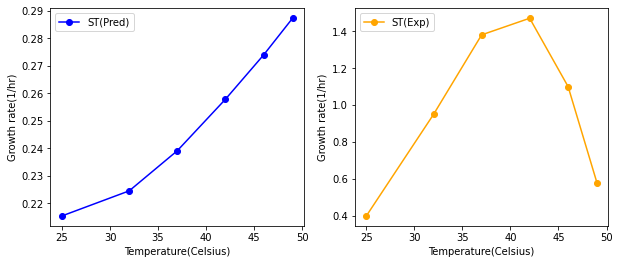

In [17]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(T_list,miu_list,color='b',marker='o',label='ST(Pred)')
axs[1].plot(T_list,[0.4,0.95,1.38,1.47,1.1,0.58],color='orange',marker='o',label='ST(Exp)')
for ax in axs:
    ax.legend()
    ax.set_xlabel('Temperature(Celsius)')
    ax.set_ylabel('Growth rate(1/hr)')

In [18]:
# for T in [25, 42, 49]:
#     temp_dict = kcat_dict_T[T]
#     temp_pd = pd.DataFrame(zip( list(temp_dict.keys()) , list(temp_dict.values()) ), columns=['RXN','pred_kcat'])
#     temp_pd.to_csv('../data/GEMs/ST_predkcat_T' + str(T) +'.csv', index=None)

## 2. L.lactis case study

In [19]:
def init_ll_medium():
    out_medium = {}
    vitamins = ['EX_pnto_R_e', 'EX_ribflv_e', 'EX_thm_e', 'EX_fol_e', 'EX_nac_e']
    DNA_materials = ['EX_ade_e', 'EX_gua_e', 'EX_xan_e', 'EX_ura_e','EX_thymd_e']
    others = ['EX_mn2_e','EX_so4_e', 'EX_h2o_e', 'EX_h_e', 'EX_pi_e', 'EX_nh4_e']
    out_medium['EX_glc_e'] = 100
    for k in ['EX_his_L_e', 'EX_ile_L_e', 'EX_leu_L_e', 'EX_lys_L_e', 'EX_met_L_e', 
                     'EX_phe_L_e', 'EX_thr_L_e', 'EX_trp_L_e', 'EX_val_L_e', 'EX_ala_L_e', 
                     'EX_arg_L_e', 'EX_asn_L_e', 'EX_asp_L_e', 'EX_cys_L_e', 'EX_gln_L_e', 
                     'EX_glu_L_e', 'EX_gly_e', 'EX_pro_L_e', 'EX_ser_L_e', 'EX_tyr_L_e']:
        out_medium[k] = 0.5
    for EX_m in (vitamins+DNA_materials):
        out_medium[EX_m] = 10
    for EX_m in others:
        out_medium[EX_m] = 1000
    return out_medium

def set_ll_PA( model, ptot, kcat_dict, mw_dict ):
    expr = model.reactions.biomass_LLA.flux_expression/fixed_cost['Growth'] + \
        model.reactions.EX_ac_e.flux_expression/fixed_cost['EX_ac_e'] + \
        model.reactions.EX_lac_L_e.flux_expression/fixed_cost['EX_lac_L_e']  
    for r in kcat_dict.keys():
        mw = mw_dict[r]/1000 # g/mmol
        kcat = kcat_dict[r]*3600 # 1/hr
        expr = expr + model.reactions.get_by_id(r).flux_expression * mw/kcat
    PA = model.problem.Constraint( expression = expr,name = 'PA', lb= 0, ub = 0.5*ptot)
    model.add_cons_vars([ PA ])
    return expr

In [20]:
predLL = pd.read_csv('../data/GEMs/predLL_primary.csv')

In [22]:
kcat_dict_T = {}
Ptot_ll = 0.46
T_list = [30,32,34,36,38]
miu_list, GLCpts, LDH, PFL, ACK = [],[],[],[],[]

rxns = list( np.unique(predLL['rxn']) )
for T in T_list:
    kcat_dict, mw_dict = {}, {}
    for rxn in rxns:
        temp_pd = predLL[predLL['rxn']==rxn].reset_index().drop(['index'],axis=1)
        if len( np.unique(temp_pd['uniprot_id']) ) == 1:
            kcat_dict[rxn] = 10**list( temp_pd['pred_log10kcat_T' + str(float(T))] )[0]
            mw_dict[rxn] = list(temp_pd['mw'])[0]
        else:
            temp_pd = temp_pd.sort_values(by=['pred_log10kcat_T' + str(float(T))],ascending=False)
            kcat_dict[rxn] = 10**list( temp_pd['pred_log10kcat_T' + str(float(T))] )[0]
            mw_dict[rxn] = list(temp_pd['mw'])[0]
            
    kcat_dict_T[T] = kcat_dict    
    with ll:
        ll.medium = init_ll_medium()
        set_ll_PA(ll, Ptot_ll, kcat_dict, mw_dict  )
        fluxes = cobra.flux_analysis.pfba( ll )
        miu_list.append(fluxes['biomass_LLA'])
        GLCpts.append(fluxes['GLCpts'])
        LDH.append( fluxes['LDH_L'] )
        PFL.append( fluxes['PFL'] )
        ACK.append( fluxes['ACKr'] )  

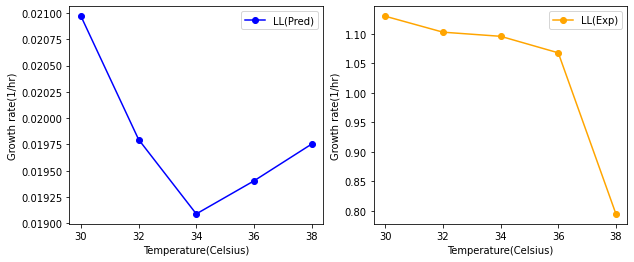

In [23]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(T_list,miu_list,color='b',marker='o',label='LL(Pred)')
axs[1].plot(T_list,[1.13,1.103,1.096,1.068,0.795],color='orange',marker='o',label='LL(Exp)')
for ax in axs:
    ax.legend()
    ax.set_xlabel('Temperature(Celsius)')
    ax.set_ylabel('Growth rate(1/hr)')

In [26]:
# for T in [30,38]:
#     temp_dict = kcat_dict_T[T]
#     temp_pd = pd.DataFrame(zip( list(temp_dict.keys()) , list(temp_dict.values()) ), columns=['RXN','pred_kcat'])
#     temp_pd.to_csv('../data/GEMs/LL_predkcat_T' + str(T) +'.csv', index=None)